I. Import data and libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import inception_v3

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import os
import sys
import random
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil
import matplotlib.pyplot as plt
import keras

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
def download_and_uncompress_tarball(tarball_url, dataset_dir): 
    filename = tarball_url.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (
            filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dataset_dir)

In [4]:
database_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'

root_folder = r"C:\D\working"
download_folder = root_folder + '\\'+ 'data\lfw_original'
selection_folder = root_folder + '\\' + 'data\lfw_selection'
download_path = download_folder + '\\lfw-deepfunneled.tgz'

if not os.path.exists(download_folder):
    os.makedirs(download_folder)

if not os.path.exists(selection_folder):
    os.makedirs(selection_folder)
    
if not os.path.exists(download_path):
    download_and_uncompress_tarball(database_url, download_folder)

In [5]:
extracted_folder = download_folder + '\\lfw-deepfunneled'

subfolders = [x[0] for x in os.walk(extracted_folder)]

subfolders.pop(0)

'C:\\D\\working\\data\\lfw_original\\lfw-deepfunneled'

II. Data exploration

In [6]:
people_list = []

for path in subfolders:
    image_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    people_list.append((path.split('\\')[-1], image_count))
    
#Sort from max to min images per person
people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

In [7]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

Number of people: 5749
Number of people with only one photo: 4069
Number of people with >=5 photos: 423


In [8]:
os.listdir(extracted_folder)

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

In [9]:
extracted_folder

'C:\\D\\working\\data\\lfw_original\\lfw-deepfunneled'

In [10]:
selected_persons = {}
i = 0

for person,image_count in people_list:
    if image_count >=5:
        file_list = []
        
        #Create new folder in selected images path
        newpath = selection_folder + '\\' + person.split('\\')[-1]
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        #Copy / paste first 5 images to the new location
        files = [os.path.join(extracted_folder, os.path.join(person, f)) for f in os.listdir(extracted_folder + '\\' + person)]
        files = files[0:5] #Select first 5 images
        for file in files:
            filename = file.split('\\')[-1]
            shutil.copyfile(file, newpath + '\\' + filename)
            file_list.append(newpath + '\\' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

In [11]:
triplets = []

for item in selected_persons.items():
    images = item[1]
    
    for i in range(len(images)-1): #run from 0 đến 4
        for j in range(i+1,len(images)): #run from 1 đến 5
            anchor = images[i]
            positive = images[j]
            
            #First generate a random class rank and make sure we're not selecting the current class to choose a random negative
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
                
            #Selected a random image from the 5 that any of our classes has
            random_image = random.randint(0, 4)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))

In [12]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3) 
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, (224, 224)) 
    return image

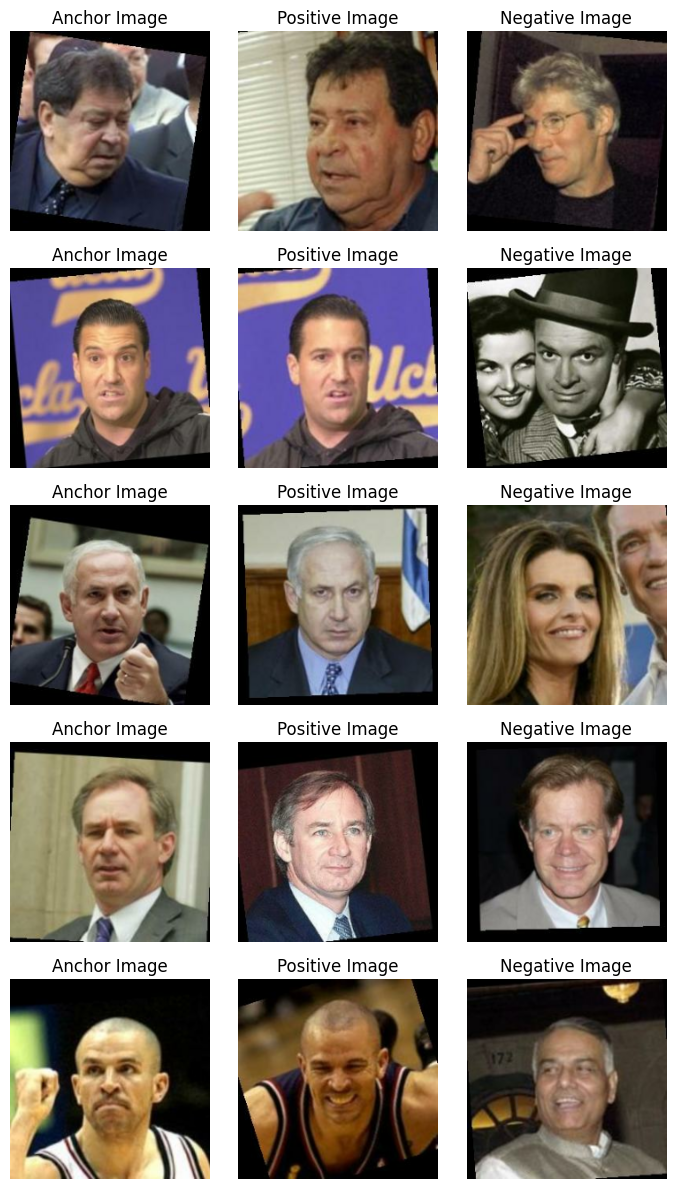

In [13]:
def show_image(ax, image):
    ax.imshow(image)
    ax.axis('off')

fig, axes = plt.subplots(5, 3, figsize=(7, 12))

for i, ax_row in enumerate(axes):
    L = np.random.randint(0, len(triplets))    
    ax1, ax2, ax3 = ax_row
    
    show_image(ax1, preprocess_image(triplets[L][0]))
    ax1.set_title('Anchor Image')
    show_image(ax2, preprocess_image(triplets[L][1]))
    ax2.set_title('Positive Image')
    show_image(ax3, preprocess_image(triplets[L][2]))
    ax3.set_title('Negative Image')

plt.tight_layout()

In [14]:
# def show_image(ax, image):
#     ax.imshow(image)
#     ax.axis('off')

# fig, axarr = plt.subplots(5, 3, figsize=(7, 12))

# for i in range(5):
#     L = np.random.randint(0, len(triplets))
    
#     show_image(axarr[i,0], preprocess_image(triplets[L][0]))
#     axarr[i,0].title.set_text('Anchor Image')
#     show_image(axarr[i,1], preprocess_image(triplets[L][1]))
#     axarr[i,1].title.set_text('Positive Image')
#     show_image(axarr[i,2], preprocess_image(triplets[L][2]))
#     axarr[i,2].title.set_text('Negative Image')

# plt.tight_layout()

In [15]:
#Transforming a tuple of filenames into a tuple of corresponding tensors
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [16]:
rng = np.random.RandomState(seed=101)
rng.shuffle(triplets)

In [17]:
anchor_images = [a_tuple[0] for a_tuple in triplets]
positive_images = [a_tuple[1] for a_tuple in triplets]
negative_images = [a_tuple[2] for a_tuple in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024) #dòng này làm val loss giảm rất nhiều, mô hình cũng rất ổn định
dataset = dataset.map(preprocess_triplets)

In [18]:
batch_size = 32
training_data = dataset.take(int(0.8 * len(dataset)))
validation_data = dataset.skip(int(0.8 * len(dataset)))

training_data = training_data.batch(batch_size, drop_remainder=False)
training_data = training_data.prefetch(1)

validation_data = validation_data.batch(batch_size, drop_remainder=False)
validation_data = validation_data.prefetch(1)

III. Build model

In [19]:
target_size = (224, 224, 3)
inception_model = InceptionV3(weights='imagenet', input_shape = target_size, include_top=False)
#inception_model.summary()

In [20]:
flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512)(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_1 = layers.Activation('relu')(dense_layer_1)
dense_layer_1 = layers.Dropout(0.1)(dense_layer_1)

dense_layer_2 = layers.Dense(256)(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
dense_layer_2 = layers.Activation('relu')(dense_layer_2)
dense_layer_2 = layers.Dropout(0.3)(dense_layer_2)

dense_layer_3 = layers.Dense(256, activation='relu')(dense_layer_2)

for layer in inception_model.layers:
    layer.trainable = False

transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_3)
transfer_inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
anchor = layers.Input(name='anchor', shape = target_size)
positive = layers.Input(name='positive', shape = target_size)
negative = layers.Input(name='negative', shape = target_size)

anchor_embedding = transfer_inception_model(inputs = anchor)
positive_embedding = transfer_inception_model(inputs = positive)
negative_embedding = transfer_inception_model(inputs = negative)

siamese_network = Model(inputs=[anchor, positive, negative], outputs=[anchor_embedding, positive_embedding, negative_embedding])
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [22]:
#Build custom class
class SiameseModelClass(Model):
    def __init__(self, siamese_model, margin=0.5):
        super(SiameseModelClass, self).__init__()
        self.siamese_model = siamese_model
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_model(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            anchor, positive, negative = data
            loss = self.custom_loss(anchor, positive, negative)

        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        anchor, positive, negative = data
        loss = self.custom_loss(anchor, positive, negative)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def custom_loss(self, anchor, positive, negative):
        anchor_embedding, positive_embedding, negative_embedding = self.siamese_model([anchor, positive, negative])

        d1 = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), -1)
        d2 = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), -1)

        # Compute triplet loss
        loss = tf.maximum(d1 - d2 + self.margin, 0)

        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [23]:
siamese_model = SiameseModelClass(siamese_network)
siamese_model.compile(optimizer = optimizers.Adam(0.0001), weighted_metrics=[]) 

IV. Train model

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.00000001) 

earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

checkpoint_path = "model.h5" 
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1, save_weights_only=True)

In [25]:
history = siamese_model.fit(training_data, epochs=40, validation_data = validation_data, callbacks = [checkpoint, learning_rate_reduction, earlystop])

Epoch 1/40
106/106 [==============================] - ETA: 0s - loss: 3.0926
Epoch 1: val_loss improved from inf to 0.58082, saving model to model.h5
106/106 [==============================] - 24s 151ms/step - loss: 3.0926 - val_loss: 0.5808 - lr: 1.0000e-04
Epoch 2/40
106/106 [==============================] - ETA: 0s - loss: 0.5096
Epoch 2: val_loss improved from 0.58082 to 0.28061, saving model to model.h5
106/106 [==============================] - 14s 130ms/step - loss: 0.5096 - val_loss: 0.2806 - lr: 1.0000e-04
Epoch 3/40
106/106 [==============================] - ETA: 0s - loss: 0.1920
Epoch 3: val_loss improved from 0.28061 to 0.21105, saving model to model.h5
106/106 [==============================] - 14s 131ms/step - loss: 0.1920 - val_loss: 0.2110 - lr: 1.0000e-04
Epoch 4/40
106/106 [==============================] - ETA: 0s - loss: 0.1775
Epoch 4: val_loss did not improve from 0.21105
106/106 [==============================] - 13s 126ms/step - loss: 0.1775 - val_loss: 0.2172

In [26]:
siamese_network.load_weights("model.h5")

In [27]:
face_embeddings = siamese_network.layers[-1]


In [28]:
face_embeddings


V. Evaluate model

In [29]:
print(history.history.keys())


dict_keys(['loss', 'val_loss', 'lr'])


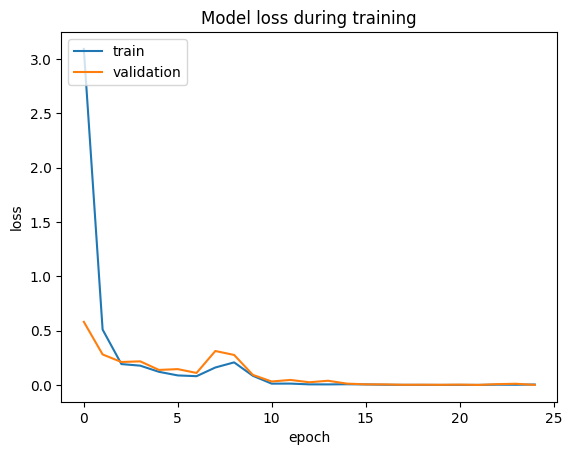

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
anchor_embedding, positive_embedding, negative_embedding = siamese_network.predict(next(iter(validation_data.take(3))))

1/1 [==============================] - 2s 2s/step


In [32]:
d1 = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), -1)
d2 = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), -1)

loss = d1 - d2 + 0.5
loss    

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-22.172356 , -13.23274  , -12.754915 ,  -5.1362495, -16.719675 ,
       -12.060602 , -29.961998 , -19.036198 , -48.957577 , -15.116455 ,
        -6.186924 , -17.83969  , -33.550022 , -27.485645 , -59.642006 ,
       -13.247011 ,  -1.0506582,  -0.3581915,  -7.186081 , -10.770189 ,
       -31.509277 , -33.150185 , -44.615456 , -58.14113  , -19.886538 ,
        -6.3183303, -14.480978 , -21.637508 , -17.91089  , -38.389465 ,
       -61.939606 , -20.802137 ], dtype=float32)>

In [33]:
count_greater_than_zero = tf.math.count_nonzero(loss > 0)
count_less_than_zero = tf.math.count_nonzero(loss < 0)

print("Số lượng phần tử lớn hơn 0:", count_greater_than_zero.numpy())
print("Số lượng phần tử bé hơn 0:", count_less_than_zero.numpy())

Số lượng phần tử lớn hơn 0: 0
Số lượng phần tử bé hơn 0: 32


In [34]:
print(f'Sum Anchor-positive difference in batch = {np.sum(d1, dtype = np.float64)}')
print(f'Sum Anchor-negative difference in batch= {np.sum(d2, dtype = np.float64)}')
print(f'Sum Loss in batch = {np.sum(loss, dtype = np.float64)}')

Sum Anchor-positive difference in batch = 376.2838101387024
Sum Anchor-negative difference in batch= 1133.5304918289185
Sum Loss in batch = -741.2466826438904


In [35]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

Positive similarity: 0.9145503
Negative similarity: 0.8296427
